In [7]:
import os
import sys
import pandas  as pd
import numpy  as np
from datetime import date
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import pickle
import networkx as nx
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
DRIVE_PATH='G:'+os.sep+'My Drive'+os.sep+'SECRET-ITN'+os.sep+'Projects'+os.sep
sys.path.append(DRIVE_PATH+'network_signing'+os.sep)
from glob_vars import SPECIES, PERT_MAP, TRAIN_DATA, KO_VAL_HOME, KO_VAL_OUT


##############################################################################
#  INPUTS
##############################################################################


HOME_DIR  =  "G:" +os.sep+"My Drive"+ os.sep +"SECRET-ITN" + os.sep +"Projects" + os.sep 
#HOME_DIR  =  "G:" +os.sep+"Il mio Drive"+ os.sep +"SECRET-ITN" + os.sep +"Projects" + os.sep 

DATA_DIR = HOME_DIR+'Data'+os.sep+SPECIES+os.sep
IMG_DIR=HOME_DIR+"network_signing"+os.sep+'imgs'+os.sep+'v3'+os.sep+SPECIES+os.sep
logfile=DIRECTED_DIR+os.sep+'validation_out'+os.sep+'crossvalidationslog.txt'
DATE=str(date.today())
dataset_name = '_'.join(TRAIN_DATA)
pert_map = 'Holstege'#'ADPBH_1' #'ADPBH_1000'#'reimand' ##  human: 'ADPBH_1 'ADPBH_1000'  'K562gwps' 
sampling = ''#'_DS'
finaldataname=dataset_name+'_'+PERT_MAP+sampling
comments=sampling


## Description

For every knockout-target pair shortest path 'sp',
avg_edge_score_per_sp_of = average across all shortest paths per position
edge_score_per_sp_of = all scores

## Distribution of probabilites of average SPs for all possible knockout-MINUS target pair
all probabilites are calculat4ed by first training a classifier without the feature from the desireed knockout, and then applying it to the shortest pathe edges.




In [8]:
TSIGN='MINUS'
with open(KO_VAL_OUT+TSIGN+'_avg_SP_edges_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    MINUSTmeanSP=pickle.load(f)
with open(KO_VAL_OUT+TSIGN+'_SP_edges_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    MINUSTSP=pickle.load(f)

In [9]:
tot=0
for K,Ts in MINUSTmeanSP.items():
    tot+=len(Ts)
print(tot, 'negative KT pairs')

1129 negative KT pairs


# Number of shortest paths per path 

# number of terminals per KO

Text(0.5, 1.0, '# terms per KO')

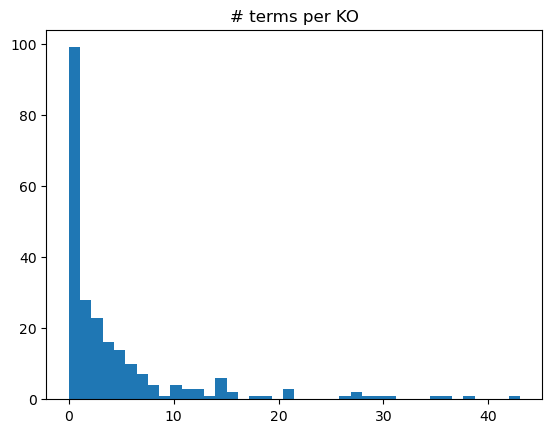

In [13]:
nT=[]
for termsdict in MINUSTmeanSP.values():
    nT.append(len(list(termsdict.keys())))
plt.hist(nT, bins=40)
plt.title('# terms per KO')

Text(0.5, 1.0, 'Probability distributions for shortest paths edges for negative perturbations')

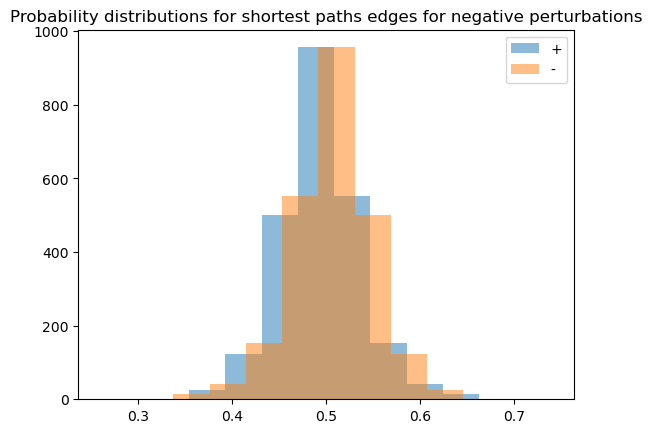

In [14]:
toplotplus=[]
toplotminus=[]
MINUStarget_minusprob = []
for termsdict in MINUSTmeanSP.values():
    for sp in termsdict.values():
        if sp.size>1:
            toplotminus.extend(sp[:,1]) # - signs
            toplotplus.extend(sp[:,0]) #+ signs
            MINUStarget_minusprob.extend(sp[:,1])
plt.hist(toplotplus, label='+', alpha=0.5)
plt.hist(toplotminus, label='-', alpha=0.5)
plt.legend()
plt.title('Probability distributions for shortest paths edges for negative perturbations')

All values separately

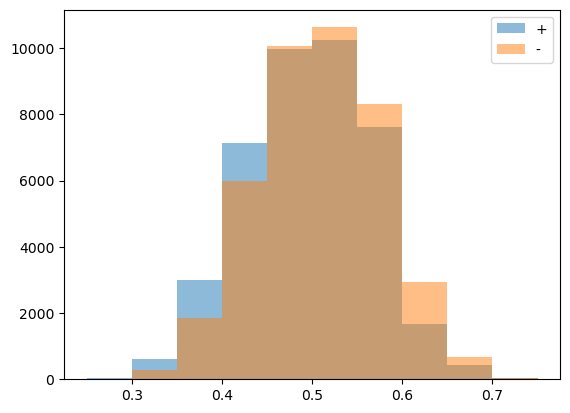

In [15]:
toplotplus=[]
toplotminus=[]
for termsdict in MINUSTSP.values():
    for sps in termsdict.values():
        for sp in sps:
            if sp.size>1:
                toplotminus.extend(sp[:,1]) # - signs
                toplotplus.extend(sp[:,0]) #+ signs
plt.figure()
plt.hist(toplotplus, label='+', alpha=0.5)
plt.hist(toplotminus, label='-', alpha=0.5)
plt.legend()

A slight offset between positive and negative perdicitions value, but centered around 0.5

## Max SP length for minus KT pairs

In [16]:
# max SP length:
maxlen=0
lens=[]
for termsdict in MINUSTmeanSP.values():
    for sp in termsdict.values():
       
        if sp.size>1:
            lens.append(sp[:,0].size)
            if sp[:,0].size > maxlen:
                maxlen=sp[:,0].size

print(maxlen)
print(pd.Series(lens).value_counts())

3
2    1006
3     116
1       4
dtype: int64


# Position-wise comparison of distributions of variables of 2-step shortest paths
Most SPs are 3 steps


In [22]:
MINUST_positions = {1:[],2:[]}
for termsdict in MINUSTmeanSP.values():
    for sp in termsdict.values():
        if sp.size>1:
            if sp[:,1].size == 2:
                for i,v in enumerate(sp[:,1]):
                    MINUST_positions[i+1].append(v)
                    

(array([ 0.03146461,  0.25171688,  0.44050455,  2.0766643 ,  5.53777147,
        10.19453384,  8.49544487,  3.30378412,  0.8810091 ,  0.44050455]),
 array([0.33      , 0.36159218, 0.39318437, 0.42477655, 0.45636874,
        0.48796092, 0.51955311, 0.55114529, 0.58273748, 0.61432966,
        0.64592185]),
 <BarContainer object of 10 artists>)

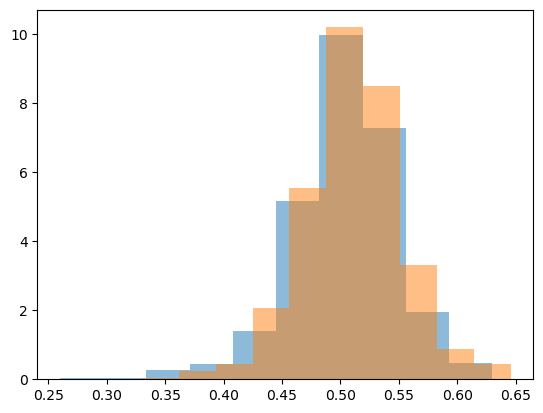

In [23]:
plt.hist(MINUST_positions[1], alpha=0.5, density=True)
plt.hist(MINUST_positions[2], alpha=0.5, density=True)


# -------- same for KT pairs that are positive

3900 positive KT pairs


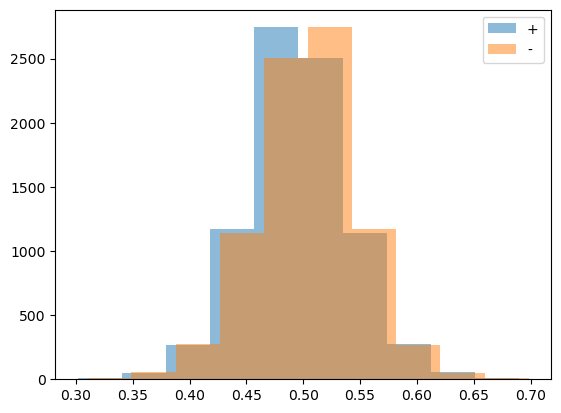

In [17]:
TSIGN='PLUS'
with open(KO_VAL_OUT+TSIGN+'_avg_SP_edges_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    PLUSTmeanSP=pickle.load(f)
with open(KO_VAL_OUT+TSIGN+'_SP_edges_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    PLUSTSP=pickle.load(f)
tot=0
for K,Ts in PLUSTmeanSP.items():
    tot+=len(Ts)
print(tot, 'positive KT pairs')
toplotplus=[]
toplotminus=[]
PLUStarget_minusprob=[]
for termsdict in PLUSTmeanSP.values():
    for sp in termsdict.values():
        if sp.size>1:
            toplotminus.extend(sp[:,1]) # - signs
            toplotplus.extend(sp[:,0]) #+ signs
            PLUStarget_minusprob.extend(sp[:,1])

plt.hist(toplotplus, label='+', alpha=0.5)
plt.hist(toplotminus, label='-', alpha=0.5)
plt.legend()  

# max sp length for positive targets Kt pairs

In [18]:
maxlen=0
lens=[]
for termsdict in PLUSTmeanSP.values():
    for sp in termsdict.values():
       
        if sp.size>1:
            lens.append(sp[:,0].size)
            if sp[:,0].size > maxlen:
                maxlen=sp[:,0].size

print(maxlen)
print(pd.Series(lens).value_counts())

4
2    3293
3     518
1      79
4       1
dtype: int64


# Compare distributions
of negative (positive) sign prediction between negative vs positive K-T pairs.


Text(0.5, 1.0, 'negative vs positive perturbation probability distributions')

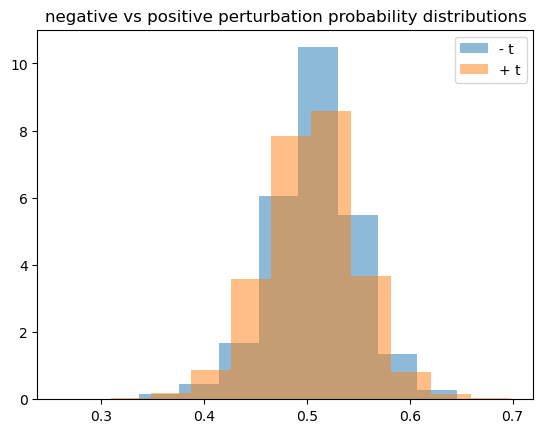

In [19]:
plt.hist(MINUStarget_minusprob, alpha=0.5, density=True, label='- t')
plt.hist(PLUStarget_minusprob, alpha=0.5, density=True, label='+ t')
plt.legend()
plt.title('negative vs positive perturbation probability distributions')

# Position-wise comparison of distributions of variables of 3-step shortest paths between plus T and minus T
Most SPs are 2 steps


In [20]:
PLUST_positions = {1:[],2:[]}
for termsdict in PLUSTmeanSP.values():
    for sp in termsdict.values():
        if sp.size>1:
            if sp[:,1].size == 2:
                for i,v in enumerate(sp[:,1]):
                    PLUST_positions[i+1].append(v)
                    

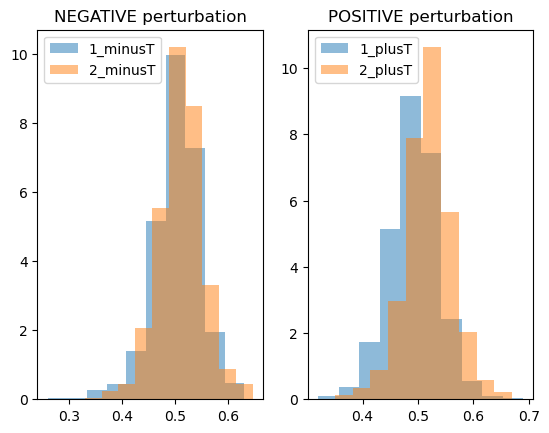

In [24]:
plt.subplot(1, 2, 1,  title='NEGATIVE perturbation')

plt.hist(MINUST_positions[1], alpha=0.5, label= '1_minusT', density=True)
plt.hist(MINUST_positions[2], alpha=0.5, label= '2_minusT', density=True)
plt.legend()

plt.subplot(1, 2, 2, title='POSITIVE perturbation')
plt.hist(PLUST_positions[1], alpha=0.5, label= '1_plusT', density=True)
plt.hist(PLUST_positions[2], alpha=0.5, label= '2_plusT', density=True)
plt.legend()

# Pathway sign reconstruction (PSR)

## 1. THreshold based
select a score based on proportion of SPs that have negative overall edge, based on a threshold


In [25]:
len(MINUSTSP.keys())

236

In [26]:
list(pd.concat([pd.Series([1,2,3]), pd.Series([1,2,3])]))

[1, 2, 3, 1, 2, 3]

In [35]:

def predict_path_sign(PLUSTSP, MINUSTSP,t=0.5, n_SPs=0, node=False):
    ''' taking into account reversal of signs'''
    
    SplusT = defaultdict(dict)
    SminusT = defaultdict(dict)

        
    def score_negative_paths_v3(paths,t, node): 
        # same result as score_negative_paths, but using -1, +1 for signs
        # and calculating product. More according to multiplicative model.
        Sminus=0
        Splus=0
        for path in paths:
            if node:
                path = np.array(list(path.values()))
            if path.size>1:
                #transform into a (0,1) array based on threshold (1= negative edge)
                if not node:
                    path=path[:,1]
                neg_nodes_p= np.where(path>=t, -1, 1) 
                if np.prod(neg_nodes_p)==-1:
                    Sminus+=1
                else:
                    Splus+=1
        return round(Sminus/(Sminus+Splus),3)
    
    def score_negative_paths(paths,t, node):
        # older version. kept for reproducibility and comparison
        Sminus=0
        Splus=0
        for path in paths:
            if node:
                path = np.array(list(path.values()))
            if path.size>1:
                #transform into a (0,1) array based on threshold (1= negative edge)
                if not node:
                    path=path[:,1]
                neg_nodes_p= np.where(path>=t, 1, 0) 
                if sum(neg_nodes_p)%2==1:
                    Sminus+=1
                else:
                    Splus+=1
        return round(Sminus/(Sminus+Splus),3)

    # S score for negative paths for positive KT pairs
    Y_true_plus = []
    for KO, SPSdict in PLUSTSP.items():
        for T, SPS in SPSdict.items():
            pair=(KO,T)
            if (len(SPS)>n_SPs): #change here which pathways to use
                SplusT[pair] = score_negative_paths_v3(SPS,t, node)
                Y_true_plus+=[1] # 0 is + T, 1 is -T
    
    
    Y_true_minus=[]
    # S score for negative paths for negative KT pairs
    for KO, SPSdict in MINUSTSP.items():
        for T, SPS in SPSdict.items():
            pair=(KO,T)
            if len(SPS)>n_SPs: #change here which pathways to use
                SminusT[pair] = score_negative_paths_v3(SPS,t, node)
                Y_true_minus+=[0] # 0 is + T, 1 is -T
    
    #serialize predicted and true values
    SplusTseries=pd.Series(SplusT)
    SminusTseries=pd.Series(SminusT)
    
    #serilize Y_true
    Y_true_plus=pd.Series(data=Y_true_plus, index=SplusTseries.index)
    Y_true_minus=pd.Series(data=Y_true_minus, index=SminusTseries.index)

    print('\t\t+',len(SplusTseries), '-', len(SminusTseries))
    return pd.concat([Y_true_plus,Y_true_minus]), pd.concat([SplusTseries,SminusTseries]), SplusT, SminusT

def calcROCAUC(Y_true, Y_pred):
    fprs, tprs, s_thresholds = roc_curve(Y_true, Y_pred)
    aucvalue=auc(fprs, tprs)
    return fprs, tprs, s_thresholds, aucvalue


## Calcualte array of values for different thresholds
calculating fprs and tprs along t and different AUCs for different levels of sdoesnt work because cant calculate AUC for tprs and fprs for t because aumentando t, in realta' il valore di S_value cambia, e a volte quindi diventa minore di un S_threshold fisso, invece piuttosto tengo fisso t, e calcoolo fprs e tprs e AUC variando s da 0 a 1 che lo posso sempre fare. e poi vedo in quali intervalli di t posso calcolare AUC. This is because S_values are calculated depending on T, but maxSvalue(t) is also depending on T, therefore sometimes the limit is higher than the threshold (ex maxSvalue for t=0.2..0.5 =1, however is equal to 0.0 for t>.., therefore, the fpr and pts are not monotone, like they go up, and then go to 0 (keeping s constant). invece cosi faccio t constant e faccio fprs e tprs cambiando l s threshold, e lo mand oda 0 a max, ma il max ce l ho.

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
tprs_of={}
fprs_of={}
AUC_of={}
best_AUC=0.0
best_params={'SP':0,'t':0}
for SP in (0, 100, 200):
    print('-------------SP:',SP)
    for t in np.arange(0,1,0.1):
        print('\tcalculating all s thresholds for t', t)
        Y_true, Y_pred, _, _ = predict_path_sign(PLUSTSP, MINUSTSP, t, SP)
        Y_true_train, Y_true_test, Y_pred_train, Y_pred_test = train_test_split(Y_true, Y_pred, test_size=0.5, random_state=42)
        fprs, tprs, s_thresholds, AUC = calcROCAUC(Y_true_train, Y_pred_train)
        tprs_of[t] = tprs
        fprs_of[t] = fprs
        AUC_of[t] = AUC
        fprs, tprs, s_thresholds, testAUC = calcROCAUC(Y_true_test, Y_pred_test)
        print('\t\ttrain AUC:', AUC_of[t],'\tvalid AUC:',testAUC)
        
        #update best model:
        if testAUC>=best_AUC:
            print('DING DING DING! best model found')
            best_AUC=testAUC
            best_params['SP']=SP
            best_params['t']=t

print('best vald auc',best_AUC,'with params:',best_params)


-------------SP: 0
	calculating all s thresholds for t 0.0
		+ 3891 - 1126
		train AUC: 0.5222553467628461 	valid AUC: 0.5246645669748999
DING DING DING! best model found
	calculating all s thresholds for t 0.1
		+ 3891 - 1126
		train AUC: 0.5222553467628461 	valid AUC: 0.5246645669748999
DING DING DING! best model found
	calculating all s thresholds for t 0.2
		+ 3891 - 1126
		train AUC: 0.5222553467628461 	valid AUC: 0.5246645669748999
DING DING DING! best model found
	calculating all s thresholds for t 0.30000000000000004
		+ 3891 - 1126
		train AUC: 0.5212631403104753 	valid AUC: 0.5244906521940508
	calculating all s thresholds for t 0.4
		+ 3891 - 1126
		train AUC: 0.5279084453198788 	valid AUC: 0.529189983961697
DING DING DING! best model found
	calculating all s thresholds for t 0.5
		+ 3891 - 1126
		train AUC: 0.5165976589067739 	valid AUC: 0.5072240476462928
	calculating all s thresholds for t 0.6000000000000001
		+ 3891 - 1126
		train AUC: 0.4952234575595393 	valid AUC: 0.503

In [291]:
print('best vald auc',best_AUC,'with params:',best_params,'however im not sure is relevant to split in train and tst as we re not training any model, but anyway it s still the same range of parameters taht yields the best results')

best vald auc 0.6917293233082706 with params: {'SP': 200, 't': 0.5} however im not sure is relevant to split in train and tst as we re not training any model, but anyway it s still the same range of parameters taht yields the best results


In [ ]:
#validation:
    Y_true, Y_pred, _, _ = predict_path_sign(PLUSTSP, MINUSTSP, t, 200)

fprs, tprs, s_thresholds, AUC = calcROCAUC(Y_true_train, Y_pred_train)


In [36]:

tprs_of={}
fprs_of={}
AUC_of={}
 #old with no train/test
for t in np.arange(0,1,0.1):
    print('calculating all s thresholds for t', t)
    Y_true, Y_pred, _, _ = predict_path_sign(PLUSTSP, MINUSTSP, t, 100)
    fprs, tprs, s_thresholds, AUC = calcROCAUC(Y_true, Y_pred)
    tprs_of[t] = tprs
    fprs_of[t] = fprs
    AUC_of[t] = AUC
    print('\tAUC:', AUC_of[t])

calculating all s thresholds for t 0.0
		+ 127 - 34
	AUC: 0.49606299212598426
calculating all s thresholds for t 0.1
		+ 127 - 34
	AUC: 0.49606299212598426
calculating all s thresholds for t 0.2
		+ 127 - 34
	AUC: 0.49606299212598426
calculating all s thresholds for t 0.30000000000000004
		+ 127 - 34
	AUC: 0.444187123668365
calculating all s thresholds for t 0.4
		+ 127 - 34
	AUC: 0.45217693376563217
calculating all s thresholds for t 0.5
		+ 127 - 34
	AUC: 0.6278369615562761
calculating all s thresholds for t 0.6000000000000001
		+ 127 - 34
	AUC: 0.5019685039370079
calculating all s thresholds for t 0.7000000000000001
		+ 127 - 34
	AUC: 0.5218851320055582
calculating all s thresholds for t 0.8
		+ 127 - 34
	AUC: 0.5
calculating all s thresholds for t 0.9
		+ 127 - 34
	AUC: 0.5


In [159]:
%matplotlib notebook

In [203]:
import ipywidgets as widgets
from IPython.display import display

def heatmap_from_dataframe(dataframe):
    heatmap = dataframe.unstack().values

    # Get the y-axis labels from the index levels
    y_ticks = sorted(dataframe.unstack().index)

    # Get the x-axis labels from the index levels
    x_ticks = sorted(dataframe.unstack().columns)

    # Create the heatmap plot
    
    fig, ax = plt.subplots()
    im = ax.imshow(heatmap, cmap='coolwarm')

    # Set the x-axis labels
    ax.set_xticks(np.arange(len(x_ticks)), x_ticks, rotation=45)

    # Set the y-axis labels
    ax.set_yticks(np.arange(len(y_ticks)), y_ticks)

    
    
    return



In [163]:

def hetmap_from_plus_minus(plus, minus):

    # Combine the keys from plus and minus dictionaries
    keys = list(plus.keys())

    # Get the list of all terminals
    all_terminals = set()
    for key in keys:
        all_terminals.update(plus[key].keys())
        all_terminals.update(minus[key].keys())

    # Create an empty heatmap array
    heatmap = np.zeros((len(all_terminals), len(keys)))

    # Populate the heatmap array based on plus and minus dictionaries
    for i, key in enumerate(keys):
        plus_terminals = plus[key].keys()
        minus_terminals = minus[key].keys()

        for j, terminal in enumerate(all_terminals):
            if terminal in plus_terminals:
                heatmap[j, i] = 1  # If terminal exists in plus dictionary, set value to 1
            elif terminal in minus_terminals:
                heatmap[j, i] = -1  # If terminal exists in minus dictionary, set value to -1

    # Create the heatmap plot
    plt.imshow(heatmap, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')

    # Set the x-axis labels
    plt.xticks(np.arange(len(keys)), keys)

    # Set the y-axis labels
    plt.yticks(np.arange(len(all_terminals)), all_terminals)

    # Adjust colorbar
    cbar = plt.colorbar(ticks=[-1, 0, 1])
    cbar.set_label('Value')

    # Show the plot
    plt.show()
    return

plus = {
    's1': {'t1s1': [], 't2s1': []},
    's2': {'t1s2': [], 't2s2': []}
    # Add more keys and values as needed
}

minus = {
    's1': {'tm1s1': [], 'tm2s1': []},
    's2': {'t1ms2': [], 't2ms2': []}
    # Add more keys and values as needed
}

    
hetmap_from_plus_minus(plus, minus)

In [149]:
def filter_plus_minus(plus, minus, edges=False): #obsoete
    plus_df=pd.Series(index=pd.DataFrame.from_dict(plus, orient='index').stack().index, data=0)
    minus_df=pd.Series(index=pd.DataFrame.from_dict(minus, orient='index').stack().index, data=1)

    concatenated = pd.concat([plus_df, minus_df])
    
    if not type(edges) == bool:
    # Filter concatenated DataFrame based on edges index
        return concatenated.loc[edges.index]
    return concatenated
#obsolete

filtered_heatmap=filter_plus_minus(PLUSTSP, MINUSTSP, Y_pred) #obsolete
Y_true_series=filter_plus_minus(PLUSTSP, MINUSTSP) #obsolete, as Y_ture is now a series already when running Y_true, Y_pred, pathSIGNALplus, pathSIGNALminus = predict_path_sign(PLUSTSP, MINUSTSP, 0.5, 200) below

<IPython.core.display.Javascript object>


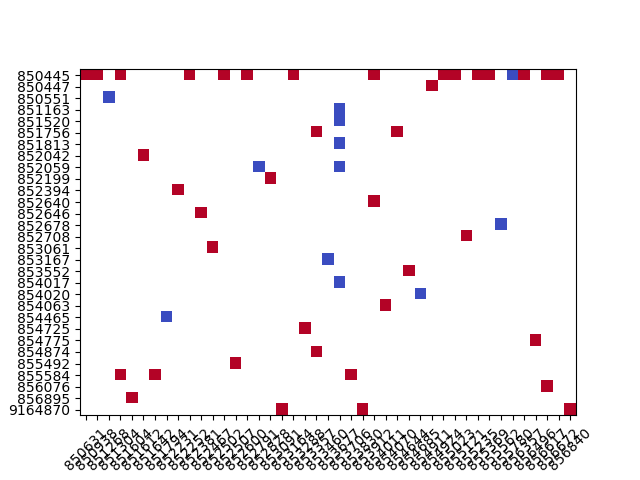

In [261]:
heatmap_from_dataframe(Y_true)

<IPython.core.display.Javascript object>


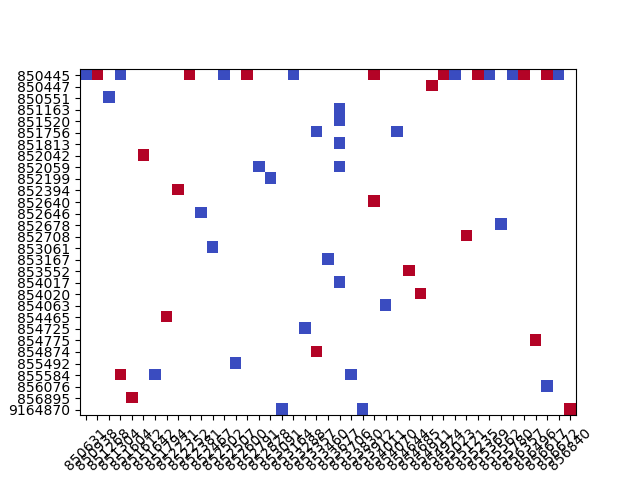

In [268]:
Y_pred_ts=pd.Series(data=np.where(Y_pred>=0.5,1,0) , index=Y_pred.index)
heatmap_from_dataframe(Y_pred_ts)

In [231]:
assignedtestYpred.value_counts()

0    29
1    21
dtype: int64

In [228]:
testYtrue.value_counts()

0    39
1    11
dtype: int64

In [260]:
fprs, tprs, s_thresholds, AUC=calcROCAUC(Y_true, Y_pred)
AUC

0.7200854700854701

In [271]:
Y_true.index==assignedYpred.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [276]:
for t in (0.1,0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9):
    print(t)
    assignedYpred=pd.Series(data=np.where(Y_pred>=0.5,1,0) , index=Y_pred.index)

    n=0
    for i, data in assignedYpred.iteritems():
        if assignedYpred[i] == Y_true[i]:
            n+=1
    print(n, n/len(Y_true))

0.1
29 0.5686274509803921
0.2
29 0.5686274509803921
0.3
29 0.5686274509803921
0.4
29 0.5686274509803921
0.5
29 0.5686274509803921
0.6
29 0.5686274509803921
0.7
29 0.5686274509803921
0.8
29 0.5686274509803921
0.9
29 0.5686274509803921


In [133]:
Y_pred.index==filtered_heatmap.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

<IPython.core.display.Javascript object>


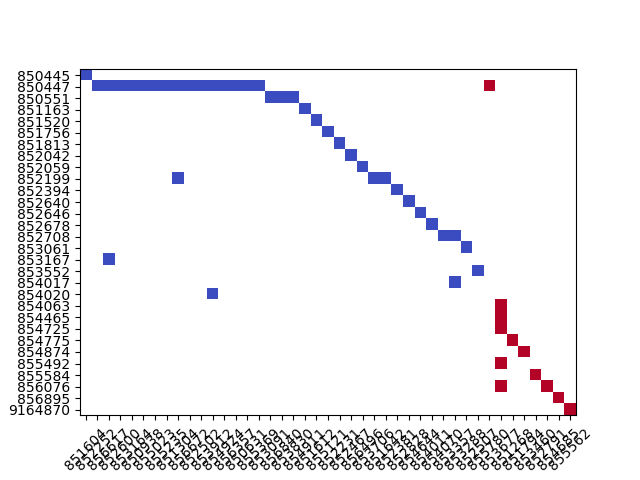

In [158]:
heatmap_from_dataframe(filtered_heatmap)

In [143]:
print(Y_pred.loc[850445,850631])
print(Y_pred.loc[850445,850938])

0.461
0.573


<IPython.core.display.Javascript object>


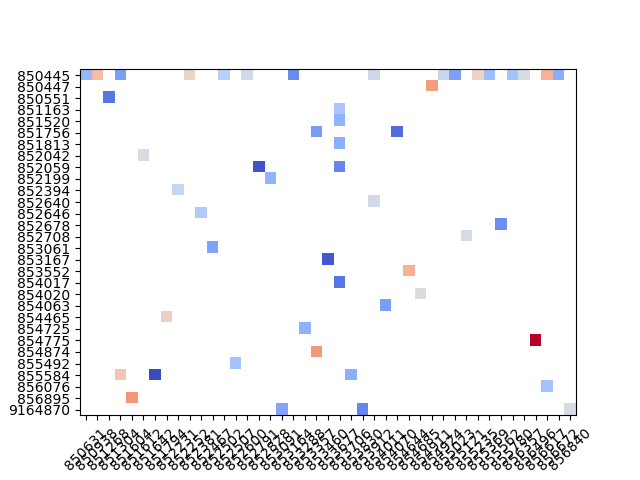

In [204]:
heatmap_from_dataframe(Y_pred)

<IPython.core.display.Javascript object>


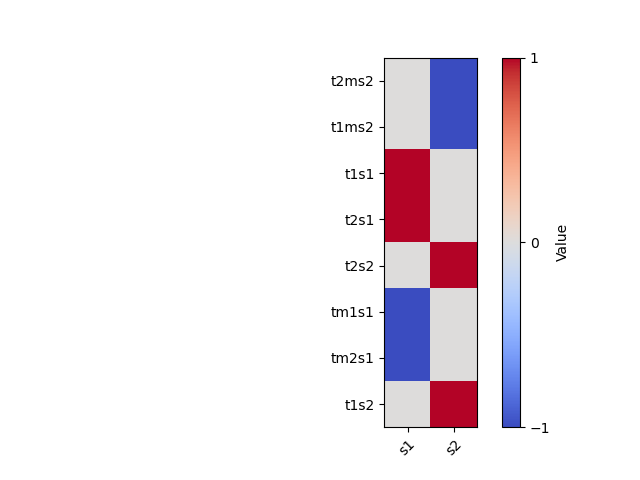

In [162]:
heatmap_from_dataframe(Y_true_series)

In [259]:
#best signal, which still has soooome datas:
Y_true, Y_pred, pathSIGNALplus, pathSIGNALminus = predict_path_sign(PLUSTSP, MINUSTSP, 0.5, 200)
fprs, tprs, s_thresholds, AUC = calcROCAUC(Y_true, Y_pred)
print(AUC)
print(s_thresholds)

		+ 39 - 12
0.7200854700854701
[1.682 0.682 0.564 0.55  0.544 0.529 0.521 0.483 0.479 0.473 0.457 0.456
 0.455 0.451 0.44  0.438 0.434 0.423 0.418 0.405 0.398 0.382 0.375]


Text(0, 0.5, 'AUC(S_score)')

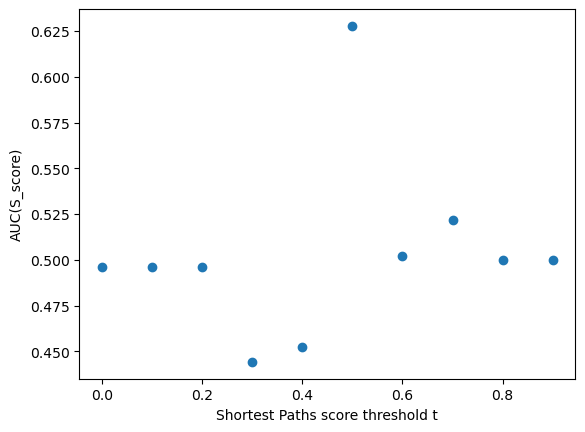

In [38]:

plt.scatter(AUC_of.keys(), AUC_of.values())
plt.xlabel('Shortest Paths score threshold t')
plt.ylabel('AUC(S_score)')



In [ ]:
help(roc_curve)

# node-based scores:

# calculate and write node based score: (only rone once)

In [6]:

def scorenode(SIGNERlist):
    return np.mean(SIGNERlist)

In [ ]:
TSIGN='MINUS'
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+TSIGN+'_SP_nodes_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    mtspna=pickle.load(f)
TSIGN='PLUS'
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+TSIGN+'_SP_nodes_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    ptspna=pickle.load(f)

def scorenode(SIGNERlist):
    return np.mean(SIGNERlist)

mtspn={}
for KO, SPSdict in mtspna.items():
    newSPSdict=defaultdict(list)#nodelist to score  
    for T, SPS in SPSdict.items():
        pair=(KO,T)
        print(pair)
        for nodeSPdict in SPS:
            print(nodeSPdict.keys()) #the nodes in the ith shortespath for KT pair pair
            nodescoreSPdict={node:scorenode(lista) for (node,lista) in nodeSPdict.items()}
            newSPSdict[T].append(nodescoreSPdict)
    mtspn[KO]=newSPSdict

ptspn={}
for KO, SPSdict in mtspna.items():
    newSPSdict=defaultdict(list)#nodelist to score  
    for T, SPS in SPSdict.items():
        pair=(KO,T)
        print(pair)
        for nodeSPdict in SPS:
            print(nodeSPdict.keys()) #the nodes in the ith shortespath for KT pair pair
            nodescoreSPdict={node:scorenode(lista) for (node,lista) in nodeSPdict.items()}
            newSPSdict[T].append(nodescoreSPdict)
    ptspn[KO]=newSPSdict
    
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+'MINUS_SP_nodescore_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'wb') as f:
    pickle.dump(mtspn,f) 

with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+'PLUS_SP_nodescore_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'wb') as f:
    pickle.dump(ptspn, f) 

# usa mtsps e ptsps come node based scores

da fare: open i files che hai scritto qui

In [39]:
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+'MINUS_SP_nodescore_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    mtspn=pickle.load(f) 

with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+'PLUS_SP_nodescore_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    ptspn=pickle.load(f)  

In [40]:
tprs_of={}
fprs_of={}
AUC_of={}
for t in np.arange(0,1,0.1):
    print('calculating all s thresholds for t', t)
    fprs, tprs, s_thresholds = calcROC(ptspn, mtspn, t, 100, node=True)
    tprs_of[t] = tprs
    fprs_of[t] = fprs
    AUC_of[t] = auc(fprs, tprs)
    print('\tAUC:', AUC_of[t])

calculating all s thresholds for t 0.0
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.1
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.2
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.30000000000000004
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.4
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.5
		+ 34 - 34
	AUC: 0.49999999999999994
calculating all s thresholds for t 0.6000000000000001
		+ 34 - 34
	AUC: 0.49999999999999994
calculating all s thresholds for t 0.7000000000000001
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.8
		+ 34 - 34
	AUC: 0.5
calculating all s thresholds for t 0.9
		+ 34 - 34
	AUC: 0.5


# add additional threshold to nodescore:
onlly prendi nodes con abbastanza scores:

## esplora distirb scores

In [3]:
TSIGN='MINUS'
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+TSIGN+'_SP_nodes_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    mtspna=pickle.load(f)
TSIGN='PLUS'
with open(DIRECTED_DIR+'validation_out'+os.sep+SPECIES+os.sep+TSIGN+'_SP_nodes_per_source_target_pair_'+dataset_name+'_'+PERT_MAP+'.pkl', 'rb') as f:
    ptspna=pickle.load(f)

(853836, 852791)
dict_keys([853836, 852755, 852791])
(853836, 853149)
dict_keys([853836, 850506, 853149])
dict_keys([853836, 850636, 853149])
dict_keys([853836, 851193, 853149])
dict_keys([853836, 851259, 853149])
dict_keys([853836, 851369, 853149])
dict_keys([853836, 851394, 853149])
dict_keys([853836, 851504, 853149])
dict_keys([853836, 851771, 853149])
dict_keys([853836, 851993, 853149])
dict_keys([853836, 852424, 853149])
dict_keys([853836, 852680, 853149])
dict_keys([853836, 852697, 853149])
dict_keys([853836, 852755, 853149])
dict_keys([853836, 853106, 853149])
dict_keys([853836, 853128, 853149])
dict_keys([853836, 853311, 853149])
dict_keys([853836, 853705, 853149])
dict_keys([853836, 854382, 853149])
dict_keys([853836, 854551, 853149])
dict_keys([853836, 854889, 853149])
dict_keys([853836, 855224, 853149])
dict_keys([853836, 855512, 853149])
dict_keys([853836, 855669, 853149])
dict_keys([853836, 855836, 853149])
dict_keys([853836, 855841, 853149])
dict_keys([853836, 856155, 853

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(array([261525.,   1696.,    753.,    524.,    416.,    334.,      0.,
           671.,    541.,    639.]),
 array([1.0000e+00, 3.6140e+02, 7.2180e+02, 1.0822e+03, 1.4426e+03,
        1.8030e+03, 2.1634e+03, 2.5238e+03, 2.8842e+03, 3.2446e+03,
        3.6050e+03]),
 <BarContainer object of 10 artists>)

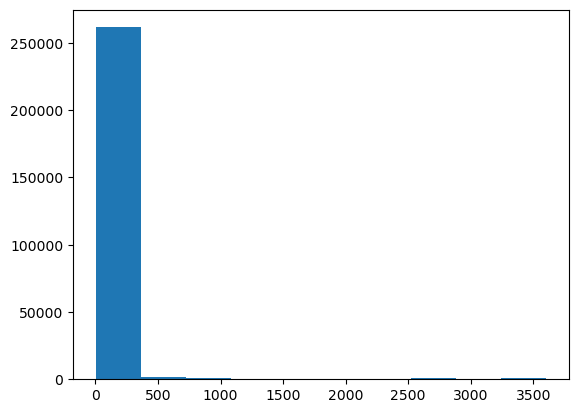

In [48]:
#takes a long time
nodescores=[]
for KO, SPSdict in mtspna.items():
    newSPSdict=defaultdict(list)#nodelist to score  
    for T, SPS in SPSdict.items():
        pair=(KO,T)
        print(pair)
        for nodeSPdict in SPS:
            print(nodeSPdict.keys()) #the nodes in the ith shortespath for KT pair pair
            nodescores+=[len(list(lista)) for lista in nodeSPdict.values()]

for KO, SPSdict in ptspna.items():
    newSPSdict=defaultdict(list)#nodelist to score  
    for T, SPS in SPSdict.items():
        pair=(KO,T)
        print(pair)
        for nodeSPdict in SPS:
            print(nodeSPdict.keys()) #the nodes in the ith shortespath for KT pair pair
            nodescores+=[len(list(lista)) for lista in nodeSPdict.values()]



(array([2.51864e+05, 3.37200e+03, 2.04700e+03, 1.34500e+03, 8.12000e+02,
        5.33000e+02, 6.25000e+02, 4.46000e+02, 2.40000e+02, 2.41000e+02,
        3.41000e+02, 1.26000e+02, 6.60000e+01, 3.01000e+02, 1.95000e+02,
        2.03000e+02, 8.00000e+01, 1.98000e+02, 1.86000e+02, 0.00000e+00,
        1.31000e+02, 8.80000e+01, 1.32000e+02, 5.60000e+01, 0.00000e+00,
        2.03000e+02, 6.10000e+01, 8.20000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 8.00000e+01, 1.52000e+02, 8.20000e+01, 0.00000e+00,
        1.03000e+02, 1.07000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.43000e+02, 0.00000e+00, 1.45000e+02, 1.28000e+02,
        0.00000e+00, 0.00000e+00, 1.52000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.82000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

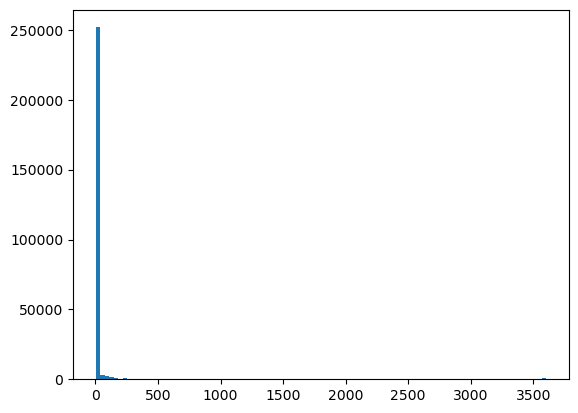

In [49]:
plt.hist(nodescores, bins=100)

In [50]:
len(nodescores)

267099

In [4]:

def scorenode(SIGNERlist):
    return np.mean(SIGNERlist)

In [9]:
def calcROCnode(PLUSTSP, MINUSTSP,t=0.5, n_SPs=0, node=False, nodescore_cutoff=0):
    ''' same like calcROC, but also with the additional cutoff for node score values
    taking into account reversal of signs'''
    Y_true = []
    SplusT = defaultdict(dict)
    SminusT = defaultdict(dict)

    def apply_node_cutoff(ShortestPaths):#list of dictionaries
        newSPS=[]
        for nodeSPdict in ShortestPaths:
            newnodescore={node: (scorenode(lista) if len(lista)>= nodescore_cutoff else -1) for (node,lista) in nodeSPdict.items() }
            newSPS.append(newnodescore)
        return newSPS
    
    def score_negative_paths(paths,t, node):
        Sminus=0
        Splus=0
        for path in paths:
            if node:
                path = np.array(list(path.values()))
            if path.size>1:
                #transform into a (0,1) array based on threshold (1= negative edge)
                if not node:
                    path=path[:,1]
                neg_nodes_p= np.where(path>=t, 1, 0) 
                if sum(neg_nodes_p)%2==1:
                    Sminus+=1
                else:
                    Splus+=1
        return round(Sminus/(Sminus+Splus),3)

    # S score for negative paths for positive KT pairs
    for KO, SPSdict in PLUSTSP.items():
        for T, SPS in SPSdict.items():
            pair=(KO,T)
            SPS = apply_node_cutoff(SPS)
            if (len(SPS)>n_SPs): #change here which pathways to use
                SplusT[pair] = score_negative_paths(SPS,t, node)
                Y_true+=[1] # 0 is + T, 1 is -T
    
    # S score for negative paths for positive KT pairs
    for KO, SPSdict in MINUSTSP.items():
        for T, SPS in SPSdict.items():
            SPS = apply_node_cutoff(SPS)
            pair=(KO,T)
            if len(SPS)>n_SPs: #change here which pathways to use
                SminusT[pair] = score_negative_paths(SPS,t, node)
                Y_true+=[0] # 0 is + T, 1 is -T
    SplusT=pd.Series(SplusT)
    SminusT=pd.Series(SminusT)
    print('\t\t+',len(SplusT), '-', len(SminusT))
    fprs, tprs, s_thresholds = roc_curve(Y_true, list(pd.concat([SplusT,SminusT])) )
    return fprs, tprs, s_thresholds

# grid-search across parameters:

In [38]:

bestscore={'AUC':0,'nodescore_cutoff':-1,'n_SPSs':-1,'t':-1}
alsobestscore={'nodescore_cutoff':[],'n_SPSs':[],'t':[]}
for nodescore_cutoff in (0, 50, 100, 200, 500):
    print('********* node cutoff', nodescore_cutoff)
    for n_SPSs in (0, 50, 100, 200):
        print('\t*********n_SPS', n_SPSs)
        tprs_of={}
        fprs_of={}
        AUC_of={}
        for t in np.arange(0,1,0.1):
            print('\t\tcalculating all s thresholds for t', t)
            fprs, tprs, s_thresholds = calcROCnode(ptspna, mtspna, t, n_SPs=n_SPSs, node=True, nodescore_cutoff=nodescore_cutoff)
            tprs_of[t] = tprs
            fprs_of[t] = fprs
            AUC_of[t] = auc(fprs, tprs)
            if AUC_of[t]>bestscore['AUC']:
                bestscore['AUC']=AUC_of[t]
                bestscore['nodescore_cutoff']=nodescore_cutoff
                bestscore['n_SPSs']=n_SPSs
                bestscore['t']=t
                alsobestcore={'nodescore_cutoff':[],'n_SPSs':[],'t':[]}
            elif AUC_of[t] == bestscore['AUC']:
                alsobestscore['nodescore_cutoff'].append(nodescore_cutoff)
                alsobestscore['n_SPSs'].append(n_SPSs)
                alsobestscore['t'].append(t)
                
            print('\t\t\tAUC:', AUC_of[t])

********* node cutoff 0
	*********n_SPS 0
		calculating all s thresholds for t 0.0
		+ 3900 - 1129
			AUC: 0.4760930935023052
		calculating all s thresholds for t 0.1
		+ 3900 - 1129
			AUC: 0.4760930935023052
		calculating all s thresholds for t 0.2
		+ 3900 - 1129
			AUC: 0.4760930935023052
		calculating all s thresholds for t 0.30000000000000004
		+ 3900 - 1129
			AUC: 0.4760930935023052
		calculating all s thresholds for t 0.4
		+ 3900 - 1129
			AUC: 0.46123015602643597
		calculating all s thresholds for t 0.5
		+ 3900 - 1129
			AUC: 0.4566046648951874
		calculating all s thresholds for t 0.6000000000000001
		+ 3900 - 1129
			AUC: 0.5013944720764915
		calculating all s thresholds for t 0.7000000000000001
		+ 3900 - 1129
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 3900 - 1129
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 3900 - 1129
			AUC: 0.5
	*********n_SPS 50
		calculating all s thresholds for t 0.0
		+ 247 - 71
			AUC: 0.5040485829959515
		calculating al

		+ 247 - 71
			AUC: 0.4900210982494156
		calculating all s thresholds for t 0.7000000000000001
		+ 247 - 71
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 247 - 71
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 247 - 71
			AUC: 0.5
	*********n_SPS 100
		calculating all s thresholds for t 0.0
		+ 131 - 34
			AUC: 0.3161203412662775
		calculating all s thresholds for t 0.1
		+ 131 - 34
			AUC: 0.3161203412662775
		calculating all s thresholds for t 0.2
		+ 131 - 34
			AUC: 0.3161203412662775
		calculating all s thresholds for t 0.30000000000000004
		+ 131 - 34
			AUC: 0.3161203412662775
		calculating all s thresholds for t 0.4
		+ 131 - 34
			AUC: 0.3079254602604401
		calculating all s thresholds for t 0.5
		+ 131 - 34
			AUC: 0.3041086663673103
		calculating all s thresholds for t 0.6000000000000001
		+ 131 - 34
			AUC: 0.4931522227211495
		calculating all s thresholds for t 0.7000000000000001
		+ 131 - 34
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 131

		+ 42 - 13
			AUC: 0.4075091575091575
		calculating all s thresholds for t 0.5
		+ 42 - 13
			AUC: 0.4358974358974359
		calculating all s thresholds for t 0.6000000000000001
		+ 42 - 13
			AUC: 0.5
		calculating all s thresholds for t 0.7000000000000001
		+ 42 - 13
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 42 - 13
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 42 - 13
			AUC: 0.5


In [16]:
bestscore

{'AUC': 0.5, 'nodescore_cutoff': 0, 'n_SPSs': 0, 't': 0.6000000000000001}

# long story short: it doesnt work
rerunning with inverted pus abd minus (WRONG just to doublecheck!)

In [39]:
bestscore={'AUC':0,'nodescore_cutoff':-1,'n_SPSs':-1,'t':-1}
alsobestscore={'AUC':[],'nodescore_cutoff':[],'n_SPSs':[],'t':[]}
for nodescore_cutoff in (0, 50, 100, 200, 500):
    print('********* node cutoff', nodescore_cutoff)
    for n_SPSs in (0, 50, 100, 200):
        print('\t*********n_SPS', n_SPSs)
        tprs_of={}
        fprs_of={}
        AUC_of={}
        for t in np.arange(0,1,0.1):
            print('\t\tcalculating all s thresholds for t', t)
            fprs, tprs, s_thresholds = calcROCnode(mtspna,ptspna, t, n_SPs=nodescore_cutoff, node=True, nodescore_cutoff=nodescore_cutoff)
            tprs_of[t] = tprs
            fprs_of[t] = fprs
            AUC_of[t] = auc(fprs, tprs)
            if AUC_of[t]>bestscore['AUC']:
                bestscore['AUC']=AUC_of[t]
                bestscore['nodescore_cutoff']=nodescore_cutoff
                bestscore['n_SPSs']=n_SPSs
                bestscore['t']=t
                alsobestcore={'nodescore_cutoff':[],'n_SPSs':[],'t':[]}
            elif AUC_of[t] == bestscore['AUC']:
                alsobestscore['AUC'].append(AUC_of[t])
                alsobestscore['nodescore_cutoff'].append(nodescore_cutoff)
                alsobestscore['n_SPSs'].append(n_SPSs)
                alsobestscore['t'].append(t)

            print('\t\t\tAUC:', AUC_of[t])

********* node cutoff 0
	*********n_SPS 0
		calculating all s thresholds for t 0.0
		+ 1129 - 3900
			AUC: 0.5239069064976948
		calculating all s thresholds for t 0.1
		+ 1129 - 3900
			AUC: 0.5239069064976948
		calculating all s thresholds for t 0.2
		+ 1129 - 3900
			AUC: 0.5239069064976948
		calculating all s thresholds for t 0.30000000000000004
		+ 1129 - 3900
			AUC: 0.5239069064976948
		calculating all s thresholds for t 0.4
		+ 1129 - 3900
			AUC: 0.5387698439735641
		calculating all s thresholds for t 0.5
		+ 1129 - 3900
			AUC: 0.5433953351048125
		calculating all s thresholds for t 0.6000000000000001
		+ 1129 - 3900
			AUC: 0.4986055279235085
		calculating all s thresholds for t 0.7000000000000001
		+ 1129 - 3900
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 1129 - 3900
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 1129 - 3900
			AUC: 0.5
	*********n_SPS 50
		calculating all s thresholds for t 0.0
		+ 1129 - 3900
			AUC: 0.5239069064976948
		calculating 

		+ 34 - 131
			AUC: 0.5068477772788504
		calculating all s thresholds for t 0.7000000000000001
		+ 34 - 131
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 34 - 131
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 34 - 131
			AUC: 0.5
	*********n_SPS 100
		calculating all s thresholds for t 0.0
		+ 34 - 131
			AUC: 0.6838796587337225
		calculating all s thresholds for t 0.1
		+ 34 - 131
			AUC: 0.6838796587337225
		calculating all s thresholds for t 0.2
		+ 34 - 131
			AUC: 0.6838796587337225
		calculating all s thresholds for t 0.30000000000000004
		+ 34 - 131
			AUC: 0.6838796587337225
		calculating all s thresholds for t 0.4
		+ 34 - 131
			AUC: 0.6920745397395599
		calculating all s thresholds for t 0.5
		+ 34 - 131
			AUC: 0.6958913336326897
		calculating all s thresholds for t 0.6000000000000001
		+ 34 - 131
			AUC: 0.5068477772788504
		calculating all s thresholds for t 0.7000000000000001
		+ 34 - 131
			AUC: 0.5
		calculating all s thresholds for t 0.8
		+ 34 

		+ 1 - 7
			AUC: 0.5
		calculating all s thresholds for t 0.9
		+ 1 - 7
			AUC: 0.5


In [28]:
bestscore

{'AUC': 0.5433953351048125, 'nodescore_cutoff': 0, 'n_SPSs': 0, 't': 0.5}

In [21]:
#UUUPs it works upside down? HMMMMMMMMMMMMMMMMMM. THink this through nexxt week

In [37]:
fprs, tprs, s_thresholds = calcROCnode(mtspna,ptspna, t=0.5, n_SPs=200, node=True, nodescore_cutoff=200)
print('\tAUC' , auc(fprs, tprs))

		+ 13 - 42
	AUC 0.7078754578754578
